Is CUDA available:  True
CUDA device count:  1
Current CUDA device:  0
CUDA device name:  NVIDIA GeForce RTX 4060 Ti
Using device: cuda


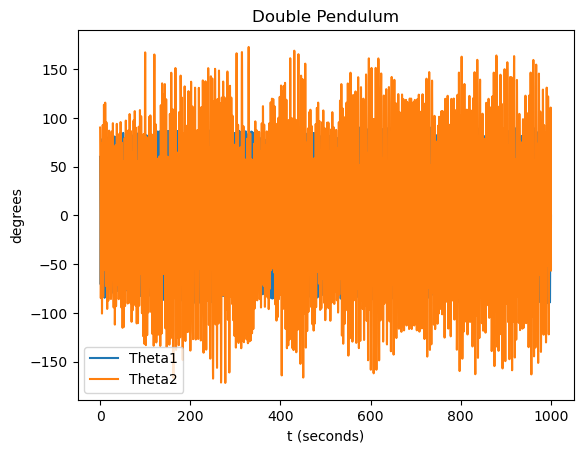

Epoch 1, Train Loss: 0.00047596154075272066, Test Loss: 3.882980570892869e-06
Epoch 2, Train Loss: 3.6361971542575586e-06, Test Loss: 4.109292143084531e-06
Epoch 3, Train Loss: 2.0076333885867825e-06, Test Loss: 8.249672989677492e-07
Epoch 4, Train Loss: 1.4295785989695276e-06, Test Loss: 1.1650614916547397e-07
Epoch 5, Train Loss: 1.1185102431092719e-06, Test Loss: 1.285552606233864e-07
Epoch 6, Train Loss: 9.496276361384837e-07, Test Loss: 7.927482700097243e-06
Epoch 7, Train Loss: 8.210642953510594e-07, Test Loss: 3.6078924016180737e-07
Epoch 8, Train Loss: 7.079214968712666e-07, Test Loss: 4.576394702979769e-07
Epoch 9, Train Loss: 6.32054890713496e-07, Test Loss: 7.409585454354328e-07
Epoch 10, Train Loss: 5.665454169064832e-07, Test Loss: 3.058163931513036e-07
Epoch 11, Train Loss: 5.162639239294497e-07, Test Loss: 2.1141577324357287e-08
Epoch 12, Train Loss: 4.7041287861476767e-07, Test Loss: 7.552413104860989e-08
Epoch 13, Train Loss: 4.370956897302991e-07, Test Loss: 1.8701282

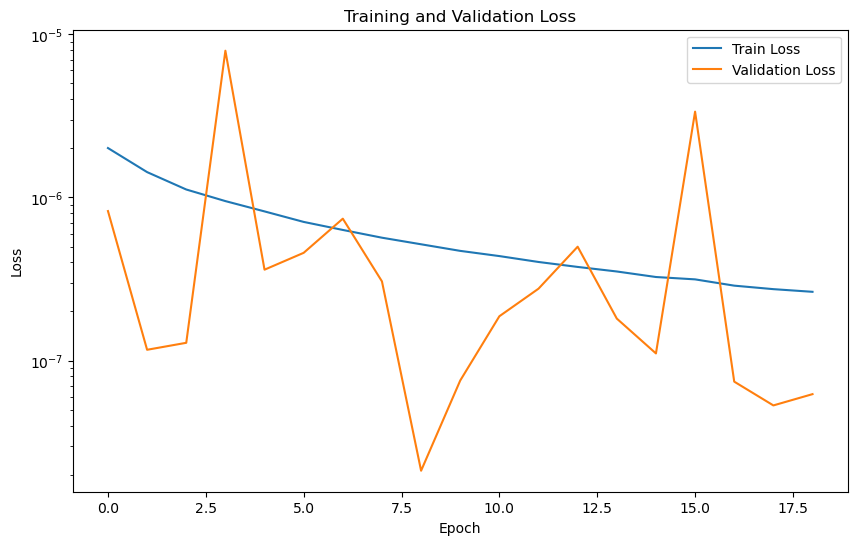

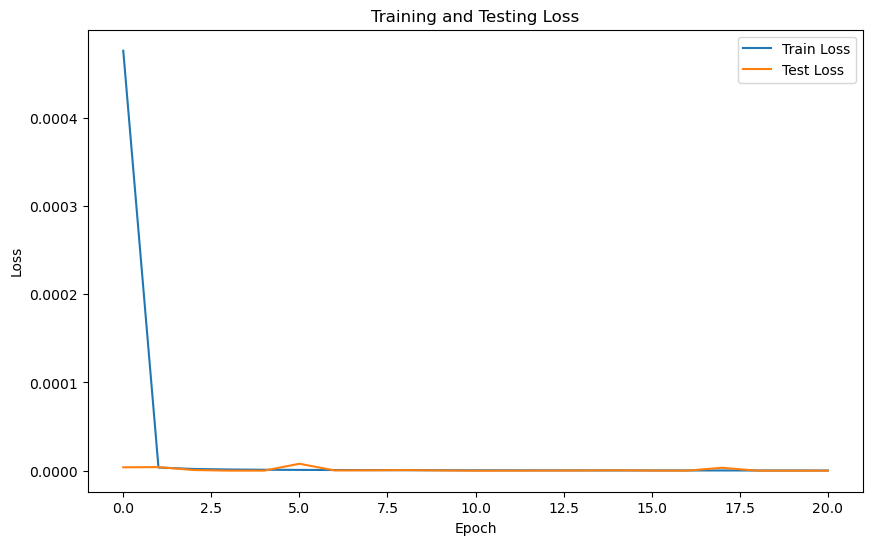

Test RMSE: 0.00024944754381431267
R^2 Score: 0.999998828270318


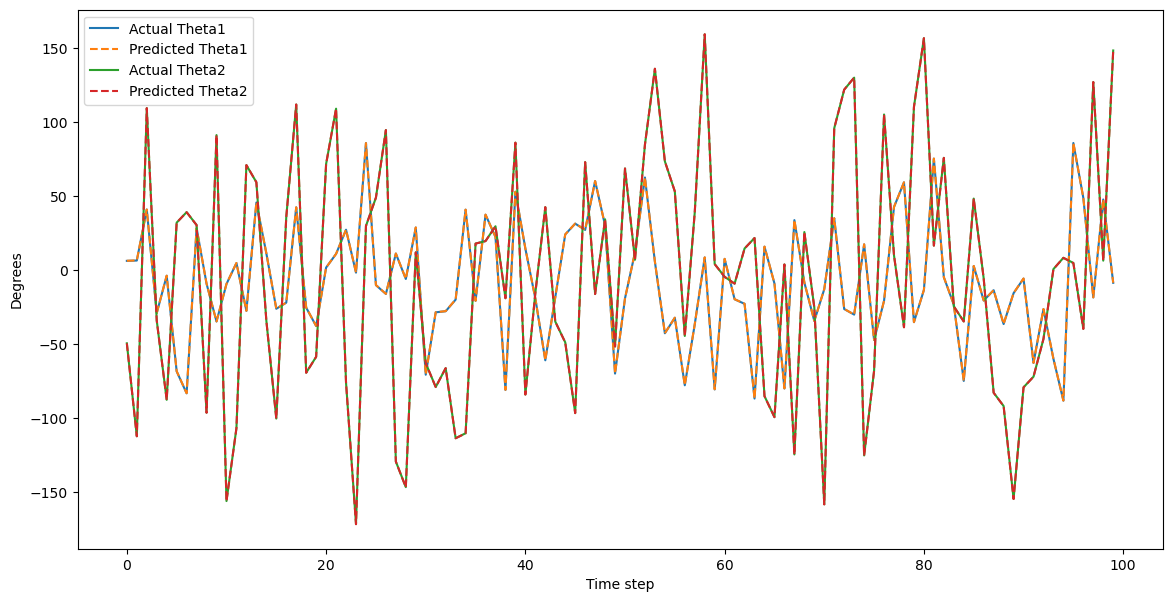

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, pi, radians
from numpy import array, arange, zeros_like
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, r2_score

print("Is CUDA available: ", torch.cuda.is_available())
print("CUDA device count: ", torch.cuda.device_count())
print("Current CUDA device: ", torch.cuda.current_device())
print("CUDA device name: ", torch.cuda.get_device_name(torch.cuda.current_device()))

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Constants
g = 9.81
L1 = 1
L2 = 1
m1 = 1.0
m2 = 1.0

# Differential equation solver
def f(r, t, L1, L2):
    theta1 = r[0]
    omega1 = r[1]
    theta2 = r[2]
    omega2 = r[3]

    ftheta1 = omega1
    fomega1 = (-g * (2 * m1 + m2) * sin(theta1) - m2 * g * sin(theta1 - 2 * theta2) - 2 * sin(theta1 - theta2) * m2 * 
               (omega2**2 * L2 + omega1**2 * L1 * cos(theta1 - theta2))) / (L1 * (2 * m1 + m2 - m2 * cos(2 * theta1 - 2 * theta2)))

    ftheta2 = omega2
    fomega2 = (2 * sin(theta1 - theta2) * (omega1**2 * L1 * (m1 + m2) + g * (m1 + m2) * cos(theta1) + omega2**2 * L2 * m2 * 
                                           cos(theta1 - theta2))) / (L2 * (2 * m1 + m2 - m2 * cos(2 * theta1 - 2 * theta2)))

    return array([ftheta1, fomega1, ftheta2, fomega2], float)

# Generate pendulum data
a = 0.0
b = 1000
N = 1000000
h = (b - a) / N

tpoints = np.arange(a, b, h)
theta1_points = np.zeros_like(tpoints)
theta2_points = np.zeros_like(tpoints)

q = np.array([pi / 3, 0, pi / 2, 0], float)

for i, t in enumerate(tpoints):
    theta1_points[i] = q[0] * 180 / pi
    theta2_points[i] = q[2] * 180 / pi

    k1 = h * f(q, t, L1, L2)
    k2 = h * f(q + 0.5 * k1, t + 0.5 * h, L1, L2)
    k3 = h * f(q + 0.5 * k2, t + 0.5 * h, L1, L2)
    k4 = h * f(q + k3, t + h, L1, L2)
    q += (k1 + 2 * k2 + 2 * k3 + k4) / 6

plt.plot(tpoints, theta1_points, label='Theta1')
plt.plot(tpoints, theta2_points, label='Theta2')
plt.title("Double Pendulum")
plt.xlabel("t (seconds)")
plt.ylabel("degrees")
plt.legend()
plt.show()

data = np.stack((theta1_points, theta2_points), axis=1)
np.save('pendulum_data.npy', data)

data = np.load('pendulum_data.npy')

scaler = MinMaxScaler()
data = scaler.fit_transform(data)

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 80
X, y = create_sequences(data, SEQ_LENGTH)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_time_step = lstm_out[:, -1, :]
        y_pred = self.linear(last_time_step)
        return y_pred

input_size = 2
hidden_layer_size = 35
output_size = 2

model = LSTMModel(input_size, hidden_layer_size, output_size).to(device)

# Initialize weights and biases
for name, param in model.named_parameters():
    if 'weight' in name:
        nn.init.xavier_normal_(param)
    elif 'bias' in name:
        nn.init.uniform_(param, -1, 1)

loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
test_losses = []

PATIENCE = 10

def train_model(model, train_loader, test_loader, num_epochs):
    best_loss = float('inf')
    epochs_without_improvement = 0
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for sequences, targets in train_loader:
            sequences, targets = sequences.to(device), targets.to(device)
            optimizer.zero_grad()
            y_pred = model(sequences)
            loss = loss_function(y_pred, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        test_loss = 0
        with torch.no_grad():
            for sequences, targets in test_loader:
                sequences, targets = sequences.to(device), targets.to(device)
                y_pred = model(sequences)
                loss = loss_function(y_pred, targets)
                test_loss += loss.item()
        test_loss /= len(test_loader)
        test_losses.append(test_loss)
        
        print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Test Loss: {test_loss}')
        
        if test_loss < best_loss:
            best_loss = test_loss
            epochs_without_improvement = 0
            best_model_wts = model.state_dict()
        else:
            epochs_without_improvement += 1
        
        if epochs_without_improvement >= PATIENCE:
            print(f'Early stopping at epoch {epoch+1}')
            break
    
    model.load_state_dict(best_model_wts)

NUM_EPOCHS = 150
train_model(model, train_loader, test_loader, NUM_EPOCHS)

# Plot the training and validation loss, skipping the first few epochs if needed
skip_epochs = 2  # Number of initial epochs to skip in the plot

plt.figure(figsize=(10, 6))
plt.plot(train_losses[skip_epochs:], label='Train Loss')
plt.plot(test_losses[skip_epochs:], label='Validation Loss')
plt.yscale('log')  # Log scale for better visualization
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()
plt.show()

def evaluate_model(model, test_loader):
    model.eval()
    test_loss = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for sequences, targets in test_loader:
            sequences, targets = sequences.to(device), targets.to(device)
            y_pred = model(sequences)
            loss = torch.sqrt(loss_function(y_pred, targets))
            test_loss += loss.item()
            all_preds.append(y_pred)
            all_targets.append(targets)
    
    avg_test_loss = test_loss / len(test_loader)
    print(f'Test RMSE: {avg_test_loss}')
    
    all_preds = torch.cat(all_preds).cpu().numpy()
    all_targets = torch.cat(all_targets).cpu().numpy()
    
    r2 = r2_score(all_targets, all_preds)
    print(f'R^2 Score: {r2}')

evaluate_model(model, test_loader)

# Predict and plot results
model.eval()
with torch.no_grad():
    for sequences, targets in test_loader:
        sequences, targets = sequences.to(device), targets.to(device)
        y_pred = model(sequences)
        break

# Separate inverse transform for each column
y_pred_np = y_pred.cpu().numpy()
targets_np = targets.cpu().numpy()

# Apply inverse transformation
y_pred_original = scaler.inverse_transform(y_pred_np)
targets_original = scaler.inverse_transform(targets_np)

# Ensure the output is in the correct shape for plotting
time_steps_to_plot = min(100, len(targets_original))  # Ensure it does not exceed available data points

plt.figure(figsize=(14, 7))
plt.plot(targets_original[:time_steps_to_plot, 0], label='Actual Theta1')
plt.plot(y_pred_original[:time_steps_to_plot, 0], label='Predicted Theta1', linestyle='dashed')
plt.plot(targets_original[:time_steps_to_plot, 1], label='Actual Theta2')
plt.plot(y_pred_original[:time_steps_to_plot, 1], label='Predicted Theta2', linestyle='dashed')
plt.xlabel('Time step')
plt.ylabel('Degrees')
plt.legend()
plt.show()


NameError: name 'animation' is not defined

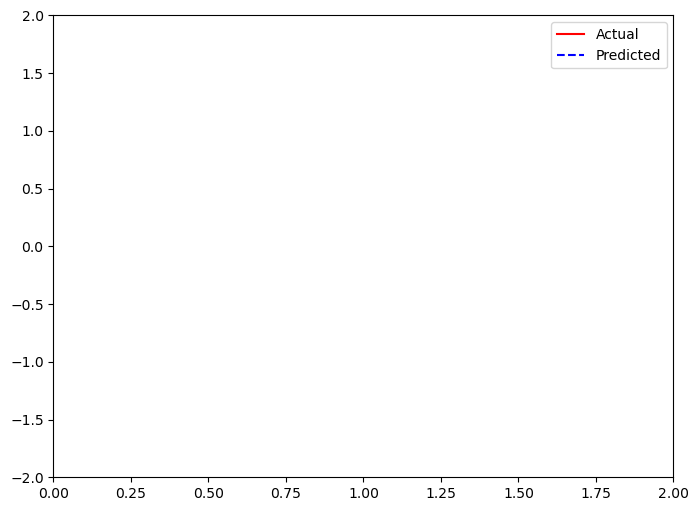

In [6]:
# Animation
fig, ax = plt.subplots(figsize=(8, 6))

line1, = ax.plot([], [], 'r-', label='Actual')
line2, = ax.plot([], [], 'b--', label='Predicted')
ax.set_xlim(0, L1 + L2)
ax.set_ylim(-L1 - L2, L1 + L2)
ax.legend()

def init():
    line1.set_data([], [])
    line2.set_data([], [])
    return line1, line2

def animate(i):
    x1 = L1 * sin(radians(targets_original[i, 0]))
    y1 = -L1 * cos(radians(targets_original[i, 0]))
    x2 = x1 + L2 * sin(radians(targets_original[i, 1]))
    y2 = y1 - L2 * cos(radians(targets_original[i, 1]))

    x1_pred = L1 * sin(radians(y_pred_original[i, 0]))
    y1_pred = -L1 * cos(radians(y_pred_original[i, 0]))
    x2_pred = x1_pred + L2 * sin(radians(y_pred_original[i, 1]))
    y2_pred = y1_pred - L2 * cos(radians(y_pred_original[i, 1]))

    line1.set_data([0, x1, x2], [0, y1, y2])
    line2.set_data([0, x1_pred, x2_pred], [0, y1_pred, y2_pred])
    return line1, line2

ani = animation.FuncAnimation(fig, animate, init_func=init, frames=len(y_pred_original), interval=20, blit=True)

plt.show()